In [1]:
# %load_ext autoreload
# %autoreload 2
try:
    import multiprocessing as mp
    mp.set_start_method('fork')
except:
    pass

In [2]:
# !pip3 install autopep8
# !conda info
import platform
platform.python_version()

'3.11.5'

# Reference

- [`Backtesting.py - Full course in python`](https://www.youtube.com/watch?v=e4ytbIm2Xg0&list=PLnSVMZC68_e48lA4aRYL1yHYZ9nEq9AiH)
- [`Backtest Your Dollar Cost Average Strategy easily in Python`](https://www.youtube.com/watch?v=Kgr8JjWX0zk&list=PLnSVMZC68_e48lA4aRYL1yHYZ9nEq9AiH&index=2)


In [3]:
import os
import numpy as np
import pandas as pd
import pandas_ta as pdta
import talib
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [4]:
yf.__version__

'0.2.28'

# Backtesting.py - Full course in python


In [5]:
from backtesting.backtesting import (
    Backtest,
    Strategy
)
from backtesting.test import (
    EURUSD,
    GOOG,
    SMA
)

from backtesting.lib import (
    crossover,
    plot_heatmaps,
    resample_apply,
    barssince
)

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),


## Simple Crossover strategy based on RSI


In [10]:
TSLA = yf.Ticker("TSLA").history(period="5y")
TSLA.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,20.384666,20.762667,20.070000,20.713333,326664000,0.0,0.0
2018-10-02 00:00:00-04:00,20.930000,21.122667,19.943333,20.068001,176152500,0.0,0.0
2018-10-03 00:00:00-04:00,20.222000,20.306667,19.438000,19.653334,119925000,0.0,0.0


In [7]:
# yf.Ticker("TSLA").info

In [8]:
class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

In [11]:
# help(Strategy.I)
# help(crossover)

bt = Backtest(
    data=TSLA,
    strategy=RsiOscillator,
    cash=10_000,
)

In [12]:
# stats = bt.run()
stats = bt.optimize(
    upper_bound=range(60, 85, 5),
    lower_bound=range(10, 40, 5),
    rsi_window=range(10, 30, 2),
    maximize='Sortino Ratio',
    constraint=lambda x: x.upper_bound > x.lower_bound
)

In [13]:
stats.to_frame()

,0
Start,2018-10-01 00:00:00-04:00
End,2023-09-28 00:00:00-04:00
Duration,1823 days 00:00:00
Exposure Time [%],64.518695
Equity Final [$],373119.100948
Equity Peak [$],455978.368618
Return [%],3631.191009
Buy & Hold Return [%],1089.475413
Return (Ann.) [%],106.594988
Volatility (Ann.) [%],109.920601


In [14]:
bt.plot(filename=os.path.join('plots', 'RsiOscillator.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1331', ...)

In [15]:
# stats._strategy
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,739,158,320,13.520000,33.139999,14499.179211,1.451183,2019-05-20 00:00:00-04:00,2020-01-09 00:00:00-05:00,234 days 01:00:00
1,980,368,773,24.980000,341.563324,310251.657944,12.673472,2020-03-19 00:00:00-04:00,2021-10-26 00:00:00-04:00,586 days 00:00:00
2,1554,1015,1256,215.330002,240.020004,38368.263794,0.114661,2022-10-12 00:00:00-04:00,2023-09-28 00:00:00-04:00,351 days 00:00:00


## Custom optimization metrics


In [16]:
def optim_func_1(series):
    #     if series['Sortino Ratio']<=0:
    #         return 0.00001
    return series['Sharpe Ratio']*series['Sortino Ratio']


def optim_func_2(series):
    if series['# Trades'] < 10:
        return -1
    return series['Equity Final [$]']/series['Exposure Time [%]']

In [17]:
stats = bt.optimize(
    upper_bound=range(55, 85, 5),
    lower_bound=range(10, 45, 5),
    rsi_window=range(10, 30, 1),
    maximize=optim_func_1,
    constraint=lambda x: x.upper_bound > x.lower_bound,
    max_tries=100
)

In [18]:
stats.to_frame()

,0
Start,2018-10-01 00:00:00-04:00
End,2023-09-28 00:00:00-04:00
Duration,1823 days 00:00:00
Exposure Time [%],54.097056
Equity Final [$],157722.515273
Equity Peak [$],187507.411574
Return [%],1477.225153
Buy & Hold Return [%],1089.475413
Return (Ann.) [%],73.840325
Volatility (Ann.) [%],79.526542


In [19]:
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1,158,312,13.520000,29.000000,15.480000,1.144970,2019-05-20 00:00:00-04:00,2019-12-27 00:00:00-05:00,221 days 01:00:00
1,635,143,312,15.724000,29.000000,8430.260015,0.844314,2019-04-29 00:00:00-04:00,2019-12-27 00:00:00-05:00,242 days 01:00:00
2,711,367,447,25.933332,110.599998,60197.999548,3.264782,2020-03-18 00:00:00-04:00,2020-07-13 00:00:00-04:00,117 days 00:00:00
3,387,612,773,202.726669,341.563324,53729.785355,0.684847,2021-03-09 00:00:00-05:00,2021-10-26 00:00:00-04:00,230 days 23:00:00
4,606,917,1183,218.339996,260.170013,25348.990356,0.191582,2022-05-23 00:00:00-04:00,2023-06-14 00:00:00-04:00,387 days 00:00:00


## heatmap


In [43]:
stats, heatmap = bt.optimize(
    upper_bound=range(55, 90, 5),
    lower_bound=range(10, 45, 5),
    # rsi_window=range(10, 30, 2),
    rsi_window=20,
    maximize='Sharpe Ratio',
    #     max_tries=100,
    constraint=lambda x: x.upper_bound > x.lower_bound,
    return_heatmap=True
)

In [44]:
heatmap.to_frame()

Sharpe Ratio
upper_bound lower_bound rsi_window              
55          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.554713
            30          20              0.000000
            35          20              0.387249
            40          20              0.202399
60          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.647421
            30          20              0.085854
            35          20              0.380150
            40          20              0.208390
65          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.744983
            30          20              0.201495
            35          20              0.578323
            40          20              0.441747
70          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.615914
            30          20              0.313924
            35          20              0.534655
            40          20              0.296472
75          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.735748
            30          20              0.456417
            35          20              0.704534
            40          20              0.474712
80          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.775810
            30          20              0.628127
            35          20              0.849924
            40          20              0.628381
85          10          20                   NaN
            15          20                   NaN
            20          20                   NaN
            25          20              0.585204
            30          20              0.804259
            35          20              0.887180
            40          20              0.758513

In [45]:
hm = heatmap.groupby(['upper_bound', 'lower_bound']).mean().unstack()

In [46]:
hm

lower_bound,10,15,20,25,30,35,40
upper_bound,,,,,,,
55,NaN,NaN,NaN,0.554713,0.000000,0.387249,0.202399
60,NaN,NaN,NaN,0.647421,0.085854,0.380150,0.208390
65,NaN,NaN,NaN,0.744983,0.201495,0.578323,0.441747
70,NaN,NaN,NaN,0.615914,0.313924,0.534655,0.296472
75,NaN,NaN,NaN,0.735748,0.456417,0.704534,0.474712
80,NaN,NaN,NaN,0.775810,0.628127,0.849924,0.628381
85,NaN,NaN,NaN,0.585204,0.804259,0.887180,0.758513


/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


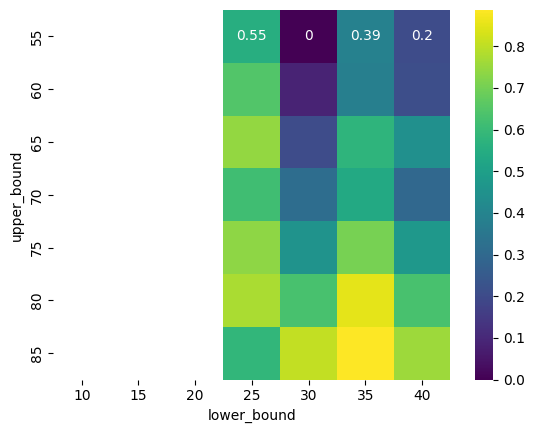

In [47]:
sns.heatmap(hm, annot=True, cmap='viridis')
plt.show()

`lower_bound=35, upper_bound=85` gives the best `Sharpe Ratio`


In [49]:
stats.to_frame()

,0
Start,2018-10-01 00:00:00-04:00
End,2023-09-28 00:00:00-04:00
Duration,1823 days 00:00:00
Exposure Time [%],75.57677
Equity Final [$],447692.826013
Equity Peak [$],576937.331704
Return [%],4376.92826
Buy & Hold Return [%],1089.475413
Return (Ann.) [%],114.281207
Volatility (Ann.) [%],128.814056


## heatmap for multiple tuning params


In [50]:
stats, heatmap = bt.optimize(
    upper_bound=range(55, 90, 5),
    lower_bound=range(10, 45, 5),
    rsi_window=range(10, 30, 2),
    maximize='Sharpe Ratio',
    #     max_tries=100,
    return_heatmap=True
)

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 490 configurations.
  output = _optimize_grid()


In [51]:
plot_heatmaps(heatmap, agg='mean', filename=os.path.join(
    'plots', 'heatmaps.html'))

GridPlot(id='p1487', ...)

In [54]:
stats._strategy

<Strategy RsiOscillator(upper_bound=85,lower_bound=25,rsi_window=18)>

In [55]:
stats.to_frame()

,0
Start,2018-10-01 00:00:00-04:00
End,2023-09-28 00:00:00-04:00
Duration,1823 days 00:00:00
Exposure Time [%],28.719173
Equity Final [$],92497.921726
Equity Peak [$],113026.118671
Return [%],824.979217
Buy & Hold Return [%],1089.475413
Return (Ann.) [%],56.202347
Volatility (Ann.) [%],50.141609


In [56]:
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,828,168,337,12.073333,58.863998,38742.671139,3.875538,2019-06-04 00:00:00-04:00,2020-02-04 00:00:00-05:00,245 days 01:00:00
1,385,1066,1256,126.370003,240.020004,43755.250587,0.899343,2022-12-23 00:00:00-05:00,2023-09-28 00:00:00-04:00,278 days 23:00:00


In [57]:
stats._equity_curve

,Equity,DrawdownPct,DrawdownDuration
2018-10-01 00:00:00-04:00,10000.000000,0.000000,NaT
2018-10-02 00:00:00-04:00,10000.000000,0.000000,NaT
2018-10-03 00:00:00-04:00,10000.000000,0.000000,NaT
2018-10-04 00:00:00-04:00,10000.000000,0.000000,NaT
2018-10-05 00:00:00-04:00,10000.000000,0.000000,NaT
...,...,...,...
2023-09-22 00:00:00-04:00,94369.021961,0.165069,NaT
2023-09-25 00:00:00-04:00,95181.372196,0.157882,NaT
2023-09-26 00:00:00-04:00,94076.418201,0.167658,NaT
2023-09-27 00:00:00-04:00,92682.720081,0.179988,NaT


## Multi-timeframe strategies

- SMA and RSI


In [63]:
class RsiOscillatorMultitimeframe(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    sma_s_window = 5
    sma_l_window = 12

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )
#         self.weekly_rsi = resample_apply(
#             'W-FRI', talib.RSI, self.data.Close,
#             self.rsi_window
#         )

        self.sma_s = self.I(
            talib.SMA,
            self.data.Close,
            self.sma_s_window
        )
        self.sma_l = self.I(
            talib.SMA,
            self.data.Close,
            self.sma_l_window
        )

    def next(self):
        if all([
            crossover(self.daily_rsi, self.upper_bound),
            self.sma_l[-1] > self.sma_s[-1]
            #             crossover(self.sma_l, self.sma_s)
        ]):
            self.position.close()
        elif all([
            crossover(self.lower_bound, self.daily_rsi),
            self.sma_l[-1] < self.sma_s[-1]
            #             crossover(self.sma_s, self.sma_l)
        ]):
            self.buy()

In [64]:
TSLA = yf.Ticker("TSLA").history(period="5y")
TSLA.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,20.384666,20.762667,20.070000,20.713333,326664000,0.0,0.0
2018-10-02 00:00:00-04:00,20.930000,21.122667,19.943333,20.068001,176152500,0.0,0.0
2018-10-03 00:00:00-04:00,20.222000,20.306667,19.438000,19.653334,119925000,0.0,0.0


In [68]:
bt = Backtest(
    TSLA,
    RsiOscillatorMultitimeframe,
    cash=10_000
)

stats = bt.optimize(
    upper_bound=range(65, 90, 5),
    lower_bound=range(15, 45, 5),
    rsi_window=range(10, 24, 2),
    sma_l_window=range(10, 24, 2),
    sma_s_window=3,
    maximize='Sortino Ratio',
)

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1470 configurations.
  output = _optimize_grid()


In [69]:
stats.to_frame()

,0
Start,2018-10-01 00:00:00-04:00
End,2023-09-28 00:00:00-04:00
Duration,1823 days 00:00:00
Exposure Time [%],83.691329
Equity Final [$],158653.614653
Equity Peak [$],270990.562635
Return [%],1486.536147
Buy & Hold Return [%],1089.475413
Return (Ann.) [%],74.045581
Volatility (Ann.) [%],118.070317


In [70]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorMultitimeframe.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1848', ...)

## Shorting


In [71]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,54.578853,54.930820,54.195761,54.413643,94403200,0.0,0.0
2018-10-02 00:00:00-04:00,54.411240,55.069682,54.262792,54.897289,99152800,0.0,0.0
2018-10-03 00:00:00-04:00,55.081655,55.900517,55.017007,55.565311,114619200,0.0,0.0


In [72]:
class RsiOscillatorLongShort(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        if crossover(self.daily_rsi, self.upper_bound):
            if self.position.is_long:
                #                 print(self.position)
                self.position.close()
                self.sell()
        elif crossover(self.lower_bound, self.daily_rsi):
            if self.position.is_short or not self.position:
                #                 print(self.position)
                self.position.close()
                self.buy()

In [73]:
bt = Backtest(
    AAPL,
    RsiOscillatorLongShort,
    cash=10_000
)

stats = bt.run()

In [74]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorLongShort.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p2210', ...)

In [ ]:
# stats.to_frame()

## Stop loss & Take profit


In [75]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,54.578837,54.930805,54.195746,54.413628,94403200,0.0,0.0
2018-10-02 00:00:00-04:00,54.411240,55.069682,54.262792,54.897289,99152800,0.0,0.0
2018-10-03 00:00:00-04:00,55.081651,55.900513,55.017003,55.565308,114619200,0.0,0.0


In [76]:
class RsiOscillatorPL(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy(
                sl=0.95*current_price,  # stop loss
                tp=1.15*current_price,  # take profit
            )

In [77]:
bt = Backtest(
    AAPL,
    RsiOscillatorPL,
    cash=10_000
)

stats = bt.run()

In [78]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorPL.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p2570', ...)

In [ ]:
# stats.to_frame()

## Size of the position


In [79]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,54.578845,54.930812,54.195754,54.413635,94403200,0.0,0.0
2018-10-02 00:00:00-04:00,54.411251,55.069693,54.262804,54.897301,99152800,0.0,0.0
2018-10-03 00:00:00-04:00,55.081666,55.900528,55.017018,55.565323,114619200,0.0,0.0


### buy in %


In [80]:
class RsiOscillatorSizePct(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy(
                size=0.1,  # every time buy 10%
            )

In [81]:
bt = Backtest(
    AAPL,
    RsiOscillatorSizePct,
    cash=10_000
)

stats = bt.run()

In [82]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizePct.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p2930', ...)

In [ ]:
# stats.to_frame()

### Buy actual # shares

- dollar cost averaging


In [ ]:
class RsiOscillatorSizeShares(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    position_size = 1

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if self.daily_rsi[-1] > self.upper_bound:
            self.position.close()
        elif self.lower_bound > self.daily_rsi[-1]:
            self.buy(
                size=self.position_size,  # every time buy 1 share
            )

In [ ]:
bt = Backtest(
    AAPL,
    RsiOscillatorSizeShares,
    cash=10_000
)

stats = bt.run()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizeShares.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p40300', ...)

In [ ]:
# stats.to_frame()

## Extracting Trade Data


In [ ]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1,187,234,34.821047,44.496325,9.675279,0.277857,2019-01-04 00:00:00-05:00,2019-03-14 00:00:00-04:00,68 days 23:00:00
1,1,181,234,35.729339,44.496325,8.766986,0.245372,2018-12-26 00:00:00-05:00,2019-03-14 00:00:00-04:00,77 days 23:00:00
2,1,180,234,35.693204,44.496325,8.803122,0.246633,2018-12-24 00:00:00-05:00,2019-03-14 00:00:00-04:00,79 days 23:00:00
3,1,179,234,37.791663,44.496325,6.704662,0.177411,2018-12-21 00:00:00-05:00,2019-03-14 00:00:00-04:00,82 days 23:00:00
4,1,163,234,42.578866,44.496325,1.917459,0.045033,2018-11-28 00:00:00-05:00,2019-03-14 00:00:00-04:00,105 days 23:00:00
5,1,162,234,41.321231,44.496325,3.175094,0.076839,2018-11-27 00:00:00-05:00,2019-03-14 00:00:00-04:00,106 days 23:00:00
6,1,161,234,41.978969,44.496325,2.517356,0.059967,2018-11-26 00:00:00-05:00,2019-03-14 00:00:00-04:00,107 days 23:00:00
7,1,160,234,42.147600,44.496325,2.348725,0.055726,2018-11-23 00:00:00-05:00,2019-03-14 00:00:00-04:00,110 days 23:00:00
8,1,159,234,43.301643,44.496325,1.194682,0.027590,2018-11-21 00:00:00-05:00,2019-03-14 00:00:00-04:00,112 days 23:00:00
9,1,290,388,42.612823,58.798180,16.185357,0.379824,2019-06-04 00:00:00-04:00,2019-10-22 00:00:00-04:00,140 days 00:00:00


## Bar Since Function


In [ ]:
class RsiOscillatorBarssince(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    position_size = 0.1

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if (self.daily_rsi[-1] > self.upper_bound) and barssince(
            self.daily_rsi < self.upper_bound
        ) == 3:
            self.position.close()
        elif (self.lower_bound > self.daily_rsi[-1]):
            self.buy(
                size=self.position_size,  # every time buy 10%
            )

In [ ]:
bt = Backtest(
    AAPL,
    RsiOscillatorBarssince,
    cash=10_000
)

stats = bt.run()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizeShares.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p44744', ...)

In [ ]:
# stats.to_frame()

# Backtest Dollar Cost Average Strategy


In [ ]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-04 00:00:00-04:00,166.600006,166.839996,165.110001,165.630005,46278300,0.0,0.0
2023-04-05 00:00:00-04:00,164.740005,165.050003,161.800003,163.759995,51511700,0.0,0.0
2023-04-06 00:00:00-04:00,162.429993,164.960007,162.000000,164.660004,45390100,0.0,0.0


In [ ]:
class DCA(Strategy):
    amt_to_invest = 10000

    def init(self):
        self.day_of_week = self.I(
            lambda x: x, self.data.Close.s.index.dayofweek,
            plot=True
        )

    def next(self):
        if self.day_of_week[-1] == 1:  # every tuesday
            self.buy(size=math.floor(
                self.amt_to_invest/self.data.Close[-1]))

In [ ]:
bt = Backtest(
    AAPL,
    DCA,
    cash=1_000_000
)
stats = bt.run()

In [ ]:
# stats.to_frame()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'DCA.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p49188', ...)

In [ ]:
trades = stats['_trades']

In [ ]:
price_paid = trades['Size']*trades['EntryPrice']
total_invested = price_paid.sum()

In [ ]:
total_invested

990800.0922727807

In [ ]:
current_shares = trades['Size'].sum()
current_equity = current_shares*AAPL.Close.iloc[-1]

In [ ]:
current_equity

3254998.952392578

# Custom Indicators In Backtesting.py


In [ ]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-04 00:00:00-04:00,166.600006,166.839996,165.110001,165.630005,46278300,0.0,0.0
2023-04-05 00:00:00-04:00,164.740005,165.050003,161.800003,163.759995,51511700,0.0,0.0
2023-04-06 00:00:00-04:00,162.429993,164.960007,162.000000,164.660004,45390100,0.0,0.0


## Random Singnal


In [ ]:
# random signal
# if we have a fancy machine learning model generated signal
# we can incorporate here
AAPL['Signal'] = np.random.randint(-1, 2, len(AAPL))

In [ ]:
class SignalStrategy(Strategy):

    def init(self):
        pass

    def next(self):
        current_signal = self.data.Signal[-1]
        if current_signal == 1:
            if not self.position.is_long:
                self.buy()
        elif current_signal == -1:
            if self.position:
                self.position.close()

In [ ]:
bt = Backtest(
    AAPL,
    SignalStrategy,
    cash=10_000
)
stats = bt.run()

In [ ]:
# stats.to_frame()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'SignalStrategy.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p51332', ...)

## Signal built with Bollinger Bands

- not a good strategy here
- `indicator` 在 `self.I` 里面运行时，`self.data.Close.s` 是必须的，转化成 series
- `indicator` 在 `self.data.Close` 上单独运行不需要`.s`


In [83]:
def indicator_bollinger(data):
    # Data - OHLCV

    bbands = pdta.bbands(
        close=data.Close.s,
        std=1
    )

    return bbands.T.to_numpy()

#     bbands = talib.BBANDS(
#         data.Close,
#         timeperiod=5,
#         nbdevup=1,
#         nbdevdn=1,
#         matype=0
#     )
#     return bbands

In [84]:
class BBStrategy(Strategy):
    def init(self):
        self.bbands = self.I(
            indicator_bollinger,
            self.data
        )

    def next(self):
        #         upper_band = self.bbands[0]
        #         lower_band = self.bbands[2]

        upper_band = self.bbands[2]
        lower_band = self.bbands[0]

        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] < lower_band[-1]:
                self.buy()

In [85]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-26 00:00:00-04:00,174.820007,175.199997,171.660004,171.960007,64588900,0.0,0.0
2023-09-27 00:00:00-04:00,172.619995,173.039993,169.050003,170.429993,66921800,0.0,0.0
2023-09-28 00:00:00-04:00,169.339996,172.029999,167.619995,170.690002,56228900,0.0,0.0


In [86]:
bt = Backtest(
    AAPL,
    BBStrategy,
    cash=10_000
)
stats = bt.run()

In [87]:
# stats.to_frame()

In [88]:
bt.plot(filename=os.path.join('plots',
                              'BBStrategy.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p3330', ...)

## Momentum strategy using pandas

- 这个 strategy 不错，跟随趋势做


In [97]:
def indicator_momentum(data):
    # Data - OHLCV
    try:
        # 在signal构建包I里使用
        return data.Close.s.pct_change(
            periods=7  # weekly change
        )*100
    except:
        # 普通使用
        return data.Close.pct_change(
            periods=7  # weekly change
        )*100

In [98]:
indicator_momentum(AAPL).tail()

2023-09-22 00:00:00-04:00    0.332924
2023-09-25 00:00:00-04:00    0.193466
2023-09-26 00:00:00-04:00   -1.742751
2023-09-27 00:00:00-04:00   -4.236674
2023-09-28 00:00:00-04:00   -4.679737
Name: Close, dtype: float64

In [99]:
class MomentumStrategy(Strategy):
    def init(self):
        self.pct_change = self.I(
            indicator_momentum,
            self.data
        )

    def next(self):
        change = self.pct_change[-1]
        if self.position:
            if change < -5:
                self.position.close()
        else:
            if change > 5:
                self.buy()

In [100]:
bt = Backtest(
    AAPL,
    MomentumStrategy,
    cash=10_000
)
stats = bt.run()

In [ ]:
# stats.to_frame()

In [101]:
bt.plot(filename=os.path.join('plots',
                              'MomentumStrategy.html'))

/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/anaconda3/envs/m1quant/lib/python3.11/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p3694', ...)

# Stop loss & Customized trailing loss


## 普通止盈止损单


In [102]:
from backtesting.backtesting import Backtest, Strategy

In [103]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01 00:00:00-04:00,54.578853,54.930820,54.195761,54.413643,94403200,0.0,0.0
2018-10-02 00:00:00-04:00,54.411240,55.069682,54.262792,54.897289,99152800,0.0,0.0
2018-10-03 00:00:00-04:00,55.081651,55.900513,55.017003,55.565308,114619200,0.0,0.0


In [106]:
class StopLossStrat(Strategy):
    def init(self):
        pass

    def next(self):
        if self.position:
            pass
        else:
            price = self.data.Close[-1]
            self.buy(
                #                 size=1,
                sl=price-5,
                tp=price+10
            )

In [107]:
bt = Backtest(
    AAPL,
    StopLossStrat,
    cash=10_000,
    trade_on_close=False,
)

stats = bt.run()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'StopLossStrat.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p77872', ...)

In [ ]:
# stats.to_frame()
trades = stats['_trades']
# trades

## Traling Stop 追踪止盈止损单


In [108]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover, TrailingStrategy

import talib

In [ ]:
class TrailingStopStrat(TrailingStrategy):
    def init(self):
        super().init()
        super().set_trailing_sl(6)

    def next(self):
        super().next()  # 先看移动止盈止损，接下来再看position

        if self.position:
            pass
        else:
            # 重新开order
            price = self.data.Close[-1]
            self.buy(
                size=1,
                sl=price-10,
                tp=price+20
            )

In [ ]:
bt = Backtest(
    AAPL,
    TrailingStopStrat,
    cash=10_000,
    trade_on_close=False  # 同一个bar卖出买进,一般不用
)

stats = bt.run()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'TrailingStopStrat.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p73027', ...)

In [ ]:
# stats.to_frame()

## Customized trailing loss

- Instead of ATR (average true range), let's use the dollar value


In [ ]:
class TrailingStrategy(Strategy):
    """
    A strategy with automatic trailing stop-loss, trailing the current
    price at distance of some multiple of average true range (ATR). Call
    `TrailingStrategy.set_trailing_sl()` to set said multiple
    (`6` by default). See [tutorials] for usage examples.
    [tutorials]: index.html#tutorials
    Remember to call `super().init()` and `super().next()` in your
    overridden methods.
    """
    __dollar_amt = 20.

    def init(self):
        super().init()

    def set_trailing_sl(self, dollar_amt: float = 6):
        self.__dollar_amt = dollar_amt

    def next(self):
        super().next()
        # Can't use index=-1 because self.__atr is not an Indicator type
        index = len(self.data)-1
        for trade in self.trades:
            if trade.is_long:
                trade.sl = max(trade.sl or -np.inf,
                               self.data.Close[index] - self.__dollar_amt)
            else:
                trade.sl = min(trade.sl or np.inf,
                               self.data.Close[index] + self.__dollar_amt)

In [ ]:
class TrailingStopStrat(TrailingStrategy):
    def init(self):
        super().init()
        super().set_trailing_sl(3)

    def next(self):
        super().next()  # 先看追踪止盈止损会overwrite已有的止盈止损单

        if self.position:
            pass
        else:
            # 重新开order
            price = self.data.Close[-1]
            self.buy(
                size=1,
                sl=price-10,
                tp=price+20
            )

In [ ]:
bt = Backtest(
    AAPL,
    TrailingStopStrat,
    cash=10_000,
    trade_on_close=False  # 同一个bar卖出买进,一般不用
)

stats = bt.run()

In [ ]:
bt.plot(filename=os.path.join('plots',
                              'TrailingStopStrat.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p72058', ...)

In [ ]:
# stats.to_frame()

In [ ]:
my_strat = MyStrategy()

In [ ]:
print(my_strat)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
1.07103088**6

1.5094264488893936